# Data Mining - Mini Lab

#### Introduction
###### Data Description
The Dallas Crime Incident data set that is used in the Mini Project acts as a bridge between the citizens of Dallas and the Dallas PD. It represents the Dallas Police Public Data - RMS Incidents from June 1, 2014 to September 7, 2018. 
For purposes of this Mini Project, the main dataframe that is trimmed based on the analysis performed as part of Lab 1. The details of the data quality clean up and choice of columns have been detailed in the Lab 1 notebook link provided below.
Lab 1 Notebook Link - https://github.com/wtubin/MSDS7331-Data-Mining/MSDS7331_Data_Mining_Lab1_Data-Viz_Pre-Processing.ipynb


#### Objective

The objective of this unit is to perform Logistic Regression and Support Vector Machines categorization on the chosen data set and optimize the parameters in order to improve the accuracy of the model.
GitHub Repository containing the artifacts - https://github.com/wtubin/MSDS7331-Data-Mining
Location of the raw (compressed) data file - https://github.com/wtubin/MSDS7331-Data-Mining/Police_Incidents.7z 

The three models are:

- Logistic Regression, using GridSearchCV, with manual variable reduction
- Logistic Regression, using GridSearchCV, with Recursive Feature Elimination (RFE)
- Support Vector Machine (SVM)



### Create Models

##### Data Preparation

The dataset is loaded and cleaning is performed with some modifications as needed to feed into model. The attributes with zero variance (closer) or those attributes that does not have value in predicting the respose variable are removed. For example attributes like beats, sector, Location1, etc. serves no purpose for our model. 

Then dataset will be splitted into explanatory, reffered as X (Attributes) and response referred as "Y" (response variable: "Arrest_status") for running the models.

        - X : Explanatory variable (attributes)
        - Y : Response variable (Arrest_status)

The attributes will be scaled to have a mean of 0 and variance of 1 in order to imporve accuracy of the classification models. The data will then be splitted in to 80/20 training/test set split. To reduce possibility of "overfitting", 10-fold cross validation will be performed. The GrisdsearchCV method with manual variable reduction will be performed and we will be utilizing correlation scores, variance inflaion scores, variance inflation factors (VIFs) and significance for manual determination of attributes. This will help us reduce the attributes for our model.These remaining attributes will also be utilized in other two models: Logistic Regression using GridSearchCV with Recursive Feature Elimination and Support Vector Machine. The scikit-learn GridSearchCV feature will be utilized to adjust model parameters for adjusting class_weight.

Overall, accuracy, precision, and recall is determined by utilizing the modification of original function created by Dr. Drew in his Education Data Notebook for clasification to check for our proper classification success. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', DeprecationWarning)
pd.set_option('mode.chained_assignment', None)

# IMPORTING DATA FROM LAB 1
path = "../Data/" # Generic path
incident = pd.read_csv(path + 'LAB1_completed_Dataset_clean.csv', low_memory= False)
print(incident.shape)
incident['Response_time'] = incident['Response_time'].fillna(incident['Response_time'].mean()).astype(np.int)
# incident['Res_time_category'] = pd.cut(incident.Response_time,[0,30,1e6],2,labels=[0,1])
# incident = incident[incident['Res_time_category'].isnull()==False]
# incident['Res_time_category'] = pd.Categorical(incident['Res_time_category']).codes

incident = incident[incident['Call_Received_Hour'].isnull()==False]

print(incident.shape)
print(incident.isnull().sum())

(255154, 44)
(254091, 44)
Year_of_Incident                0
Service_Number_ID               0
Watch                           0
Type_of_Incident                0
Type_Location                4856
Reporting_Area                155
Beat                           70
Division                        0
Sector                         70
Council_District                0
Day1_of_the_Week                0
Call_Received_Date_Time         0
Call_Cleared_Date_Time        165
Call_Dispatch_Date_Time        21
Person_Involvement_Type         0
Victim_Type                     0
Victim_Race                     0
Victim_Gender                   0
Victim_Age                      0
Offense_Status                557
Victim_Condition           233793
Hate_Crime                      0
Family_Offense                 32
Weapon_Used                 28804
Gang_Related_Offense            0
Drug_Related                    0
UCR_Offense_Name            14475
RMS_Code                        0
UCR_Code              

0    229722
1     24369
Name: Arrest_status, dtype: int64


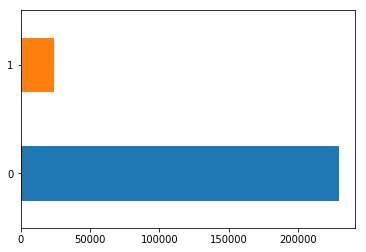

In [4]:
print(incident['Arrest_status'].value_counts())
incident['Arrest_status'].value_counts().plot(kind='barh')

In [5]:
# UCR_Offense_Name change this

incident.loc[:,'UCR_Offense_Name'] = incident['UCR_Offense_Name'].fillna("MISSING")

THEFT_FRAUD     = dict.fromkeys(['THEFT/BMV', 'THEFT ORG RETAIL', 'BURGLARY-RESIDENCE', 'OTHER THEFTS',
                                 'ROBBERY-INDIVIDUAL','THEFT/SHOPLIFT', 'BURGLARY-BUSINESS', 'FORGE & COUNTERFEIT', 
                                 'FRAUD', 'EMBEZZLEMENT','ROBBERY-BUSINESS','THEFT ORG RETAIL'],"THEFT_FRAUD" ) 
MVA_TRAFFIC      =dict.fromkeys(['ACCIDENT MV', 'MOTOR VEHICLE ACCIDENT', 'UUMV', 'TRAFFIC VIOLATION',
                                 'TRAFFIC FATALITY'],"MVA_TRAFFIC" )        
WEAPONS_FIREARMS =dict.fromkeys(['WEAPONS', 'ARSON', 'INJURED FIREARM'], "WEAPONS_FIREARMS")         
ASSUALT          = dict.fromkeys(['ASSAULT','VANDALISM & CRIM MISCHIEF', 'AGG ASSAULT - NFV', 'OFFENSE AGAINST CHILD',
                                  'AGG ASSAULT - FV'], "ASSUALT")
OTHERS_THREATS   = dict.fromkeys(['FOUND', 'OTHERS', 'LOST', 'CRIMINAL TRESPASS', 'DISORDERLY CONDUCT', 
                                  'ANIMAL BITE','INJURED HOME','INJURED PUBLIC', 'TERRORISTIC THREAT', 
                                  'EVADING', 'INJURED OCCUPA', 'ORANIZED CRIME', 'KIDNAPPING', 
                                  'RESIST ARREST','FAIL TO ID', 'HUMAN TRAFFICKING', 'MISSING'], "OTHERS_THREATS")
INTOXICATION     = dict.fromkeys(['DRUNK & DISORDERLY', 'DWI', 'NARCOTICS & DRUGS', 'LIQUOR OFFENSE', 
                                  'INTOXICATION MANSLAUGHTER'],"INTOXICATION")
MURDER_DEATH     = dict.fromkeys(['SUDDEN DEATH&FOUND BODIES','MURDER'], "MURDER_DEATH")
                    

incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(THEFT_FRAUD)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MVA_TRAFFIC)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(WEAPONS_FIREARMS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(ASSUALT)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(OTHERS_THREATS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(INTOXICATION)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MURDER_DEATH)

In [6]:
# # FILTERING OUT UNNECESSARY NULL DATA
incident = incident[incident['Watch']!=0]
incident = incident[(incident['Victim_Age']>=0) & (incident['Victim_Age']<=90)]
incident = incident[incident['Victim_Race']!="Unknown"]
incident = incident[incident['Victim_Type']!="Unknown"]
incident= incident[incident.Number_of_offense != "RP"]

incident = incident[incident['Victim_Gender']!="U"]
incident.loc[:,'IsMale'] = incident.Victim_Gender=='M' 
incident.IsMale = incident.IsMale.astype(np.int)

incident.loc[:,'Social_crime_score'] = incident['Hate_Crime']+incident['Gang_Related_Offense']+incident['Drug_Related']

incident.loc[:,'Victim_Age'] = incident['Victim_Age'].astype(np.int)
# incident.loc[:,'Victim_Age_Group'] = pd.cut(incident.Victim_Age,[-1,18,30,60,999],4,labels=[0,1,2,3])

incident['UCR_Offense_Name'] = pd.Categorical(incident['UCR_Offense_Name']).codes
incident['Day1_of_the_Week'] = pd.Categorical(incident['Day1_of_the_Week']).codes
incident['Division'] = pd.Categorical(incident['Division']).codes
incident['Victim_Type'] = pd.Categorical(incident['Victim_Type']).codes
incident['Victim_Race'] = pd.Categorical(incident['Victim_Race']).codes

incident.loc[:,'Number_of_offense']= incident.Number_of_offense.astype(np.int)

In [7]:
incident.columns

Index(['Year_of_Incident', 'Service_Number_ID', 'Watch', 'Type_of_Incident',
       'Type_Location', 'Reporting_Area', 'Beat', 'Division', 'Sector',
       'Council_District', 'Day1_of_the_Week', 'Call_Received_Date_Time',
       'Call_Cleared_Date_Time', 'Call_Dispatch_Date_Time',
       'Person_Involvement_Type', 'Victim_Type', 'Victim_Race',
       'Victim_Gender', 'Victim_Age', 'Offense_Status', 'Victim_Condition',
       'Hate_Crime', 'Family_Offense', 'Weapon_Used', 'Gang_Related_Offense',
       'Drug_Related', 'UCR_Offense_Name', 'RMS_Code', 'UCR_Code',
       'X_Coordinate', 'Y_Coordinate', 'Zip_Code', 'City', 'State',
       'Location1', 'Call_Received', 'Call_Cleared', 'Call_Dispatch',
       'Number_of_offense', 'Response_time', 'Latitude', 'Longitude',
       'Arrest_status', 'Call_Received_Hour', 'IsMale', 'Social_crime_score'],
      dtype='object')

In [8]:
# Y Response variable dataframe
inci_Y = incident['Arrest_status']

# Attributes with no predictive features with respect to resposne variable
incident = incident.drop(['Year_of_Incident','Service_Number_ID','Type_of_Incident','Type_Location', 'Reporting_Area', 
                          'Beat', 'Division', 'Sector', 'Council_District', 'Call_Received_Date_Time', 
                          'Call_Cleared_Date_Time', 'Call_Dispatch_Date_Time','Person_Involvement_Type', 'Offense_Status',
                          'Victim_Condition','Family_Offense', 'Weapon_Used', 'RMS_Code', 'UCR_Code', 
                          'Zip_Code', 'City', 'State','Location1', 'Call_Received', 'Call_Cleared', 'X_Coordinate', 
                          'Y_Coordinate','Call_Dispatch', 'Latitude', 'Longitude','Victim_Gender', 
                          'Arrest_status'],axis=1)


In [9]:
incident.sample(2)

,Watch,Day1_of_the_Week,Victim_Type,Victim_Race,Victim_Age,Hate_Crime,Gang_Related_Offense,Drug_Related,UCR_Offense_Name,Number_of_offense,Response_time,Call_Received_Hour,IsMale,Social_crime_score
169078,1,5,2,6,51,0,0,0,5,3,19,7.0,0,0
131405,3,5,2,6,32,0,0,0,0,1,4,21.0,1,0


#### Cross Validation

    1. The data is divided into 80/20 train -test split.
    2. 10 folds cross validation
    3. Random seed with random state 0 for random test and training splits for each iteration of cross validation

In [10]:
from sklearn.model_selection import ShuffleSplit
#Create Cross Validation Object with 10 folds with 80/20 train - test split
cv = ShuffleSplit(n_splits = 10, test_size=0.20, random_state=0)

#Create X Explanatory Variables DF to support the individual models
inci_X = incident
inci_X_Rfe = incident
inci_X_SVM = incident
print("inci_X", inci_X.info())
print("inci_X_Rfe", inci_X_Rfe.info())
print("inci_X_SVM", inci_X_SVM.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225452 entries, 0 to 255153
Data columns (total 14 columns):
Watch                   225452 non-null int64
Day1_of_the_Week        225452 non-null int8
Victim_Type             225452 non-null int8
Victim_Race             225452 non-null int8
Victim_Age              225452 non-null int32
Hate_Crime              225452 non-null int64
Gang_Related_Offense    225452 non-null int64
Drug_Related            225452 non-null int64
UCR_Offense_Name        225452 non-null int8
Number_of_offense       225452 non-null int32
Response_time           225452 non-null int32
Call_Received_Hour      225452 non-null float64
IsMale                  225452 non-null int32
Social_crime_score      225452 non-null int64
dtypes: float64(1), int32(4), int64(5), int8(4)
memory usage: 16.3 MB
inci_X None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 225452 entries, 0 to 255153
Data columns (total 14 columns):
Watch                   225452 non-null int64
Day1_of_

##### Colinearity

The dataset had few issues with collinearity, this issue was found during ther LAB 1 iteration of data exploration. 

###### Starting Colinearity
Some of the attributes which were hightly correlated comes from either creation of new columns or they are derived from date related varibales or splitted from original categories.

In [11]:
#Create correlation matrix
CorrMat = incident.corr()

# Highest Correlation Pairs
corrPairs = CorrMat.unstack().sort_values(kind="quicksort", ascending=False)
#- REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

Social_crime_score  Drug_Related            0.854184
Call_Received_Hour  Watch                   0.661610
Social_crime_score  Gang_Related_Offense    0.531994
Hate_Crime          Social_crime_score      0.129686
Victim_Race         UCR_Offense_Name        0.123139
                                              ...   
Response_time       Number_of_offense      -0.042444
UCR_Offense_Name    Gang_Related_Offense   -0.043005
Response_time       Drug_Related           -0.043991
                    Social_crime_score     -0.050053
Watch               UCR_Offense_Name       -0.076413
Length: 91, dtype: float64


Ending Colinearity
The highly correlated attributes were manually removed from dataset. 
- Total attributes removed : 4

In [13]:

#Drop highly correlated, insignificant and high VIF columns.
inci_X = incident.drop(['Drug_Related','Watch','Gang_Related_Offense','Hate_Crime'], axis=1)

#Create correlation matrix
CorrMat = inci_X.corr()

# Highest Correlation Pairs
corrPairs = CorrMat.unstack().sort_values(kind="quicksort", ascending=False)
#- REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

Victim_Race         UCR_Offense_Name      0.123139
                    Victim_Age            0.095114
Response_time       Call_Received_Hour    0.069421
IsMale              Victim_Race           0.063600
Victim_Age          IsMale                0.056472
                                            ...   
                    Social_crime_score   -0.031393
Call_Received_Hour  IsMale               -0.034376
Number_of_offense   Victim_Age           -0.038841
                    Response_time        -0.042444
Response_time       Social_crime_score   -0.050053
Length: 45, dtype: float64


###### Scale Data
In order to imporve accuracy and performance of our classification model and to prevent emphasis of one attribute over the other, attributes are scaled to have a mean of 0 and variance of 1 for all models in this report.Several features in the data set are decimal measurements that will never exceed 1.


In [14]:
from sklearn.preprocessing import StandardScaler

#Scale data
scaler = StandardScaler()
inci_X_scaled = scaler.fit_transform(inci_X)
inci_X_Rfe_scaled = scaler.fit_transform(inci_X_Rfe)
inci_X_SVM_scaled = scaler.fit_transform(inci_X_SVM)

#Save as data frames
df_inci_X_scaled = pd.DataFrame(inci_X_scaled)
df_inci_X_Rfe_scaled = pd.DataFrame(inci_X_Rfe_scaled)
df_inci_X_SVM_scaled= pd.DataFrame(inci_X_SVM_scaled)

#### Variance Inflation Factors (VIF)

The attributes analysis and scaling is indicated with hight variance inflation factors. Generally acceptable value should be under 10. This will help create better model. 

###### Initially, for manual reduction method for Logistic regression VIF is, 

In [15]:
# Credit: https://etav.github.io/

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df2_vif = pd.DataFrame()
df2_vif["VIF Factor"] = [vif(inci_X.values, i) for i in range(inci_X.shape[1])]
df2_vif["features"] = inci_X.columns
df2_vif

,VIF Factor,features
0,3.192771,Day1_of_the_Week
1,26.967522,Victim_Type
2,5.472996,Victim_Race
3,8.250002,Victim_Age
4,3.371974,UCR_Offense_Name
5,6.764857,Number_of_offense
6,1.692167,Response_time
7,5.163292,Call_Received_Hour
8,2.174894,IsMale
9,1.020514,Social_crime_score


##### Applying threshold of 10 VIF is,
After applying a threshold of 10 and using the Logistic Regression-with manual variable reduction, dataset, the VIF factors have been reduced significantly and are in an acceptable range.

In [16]:
# Credit: https://etav.github.io/

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

df2_vif = pd.DataFrame()
df2_vif["VIF Factor"] = [vif(df_inci_X_scaled.values, i) for i in range(df_inci_X_scaled.shape[1])]
df2_vif["features"] = inci_X.columns
df2_vif

,VIF Factor,features
0,1.000822,Day1_of_the_Week
1,1.000230,Victim_Type
2,1.027585,Victim_Race
3,1.014374,Victim_Age
4,1.022274,UCR_Offense_Name
5,1.006081,Number_of_offense
6,1.012481,Response_time
7,1.007197,Call_Received_Hour
8,1.011690,IsMale
9,1.006869,Social_crime_score


### FEATURE SIGNIFICANCE

In [17]:
# LOGISTIC REGRESSION: SUMMARY TABLE WITHOUT SCALING- FEATURE SIGNIFICANCE, CROSS VALIDATION OF FULL MODEL

import statsmodels.api as sm
logit_model = sm.Logit(inci_Y, inci_X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.304133
         Iterations 7
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.080      
Dependent Variable:  Arrest_status    AIC:              137154.5663
Date:                2018-10-03 11:54 BIC:              137257.8249
No. Observations:    225452           Log-Likelihood:   -68567.    
Df Model:            9                LL-Null:          -74535.    
Df Residuals:        225442           LLR p-value:      0.0000     
Converged:           1.0000           Scale:            1.0000     
No. Iterations:      7.0000                                        
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Day1_of_the_Week   -0.0012   0.0036  -0.3445 0.7304 -0.0083  0.0059
Victim_Type        -0.6500   0.0176 -37.0

## Logistic Regresssion

##### Classifier Evaluation

- Functions and code utilized from Dr. Drew's NC models 
https://github.com/jakemdrew/EducationDataNC/blob/master/2016/Models/2016ComparingSegregatedHighSchoolCampuses.ipynb

In [18]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

results = []

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv, model):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, inci_X, inci_Y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']
    
    results.append({'Model': model, 'Accuracy': Accavg, 'Precision': Preavg, 'Recall': Recavg})

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, inci_X, inci_Y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(Y,predictions)
    confMat = confusion_matrix(Y,predictions)
    acc = accuracy_score(Y,predictions)
    
    print (classReport)
    print (confMat)
    print (acc)

##### GridSearchCV Logistic Regression with Manual Feature Reduction

In [19]:
#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
#regGridSearch.fit(teamX, teamY)
regGridSearch.fit(df_inci_X_scaled, inci_Y)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   58.7s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:  1.4min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced', 'none'], 'random_state': [0], 'solver': ['lbfgs'], 'max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [20]:
#Diplay the top model parameters
regGridSearch.best_estimator_.coef_

array([[-0.00303158, -0.01761362, -0.05297024, -0.08600636, -0.57585523,
         0.12230415, -0.35283089,  0.05400261,  0.04129444,  0.08536841]])

#### Accuacy Precision, Recall, Attribute Weights, Model Parameters
Average accuracy, precision, and recall for the cross-validation folds is listed below.

In [21]:
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
print("\n",round(EvaluateClassifierEstimator(classifierEst, df_inci_X_scaled, inci_Y, cv, "manual"),4))

#Use the best parameters for our Linear Regression object",
ClassiferParams = regGridSearch.best_params_
print("\n---- Logistic Regression - CV, Scaled 'Manual' Attr Elimination ----")
for keys,values in ClassiferParams.items():
    print(keys,": \t ",values)
    
# sort these attributes and spit them out\n",
name = inci_X
zip_vars = zip(regGridSearch.best_estimator_.coef_.T,name) # combine attributes
zip_vars = sorted(zip_vars, reverse=True)

# Print out Attributes and their weights\n",
print("\n---- Attributes and their weights -----\n")
for coef, name in zip_vars:
    print(name, ' has weight of', coef[0])

The average accuracy for all cv folds is: 			 0.89775
The average precision for all cv folds is: 			 0.60869
The average recall for all cv folds is: 			 0.0019055
*********************************************************
Cross Validation Fold Mean Error Scores

    Accuracy  Precision  Recall
0    0.8976     0.5263  0.0022
1    0.9001     0.5294  0.0020
2    0.8974     0.5833  0.0015
3    0.8978     0.8750  0.0015
4    0.8956     0.5556  0.0021
5    0.8966     0.6667  0.0026
6    0.8988     0.5000  0.0009
7    0.8976     0.5000  0.0026
8    0.8978     0.6364  0.0015
9    0.8982     0.7143  0.0022

---- Logistic Regression - CV, Scaled 'Manual' Attr Elimination ----
C : 	  0.001
class_weight : 	  none
max_iter : 	  100
penalty : 	  l2
random_state : 	  0
solver : 	  lbfgs

---- Attributes and their weights -----

Number_of_offense  has weight of 0.12230414969571246
Social_crime_score  has weight of 0.08536841186152015
Call_Received_Hour  has weight of 0.05400260610450153
IsMale  has wei

In [22]:
print("Best Estimator GridSearch Prediction")
print(regGridSearch.best_estimator_.predict(df_inci_X_scaled))
print(regGridSearch.best_estimator_.predict_proba(df_inci_X_scaled))

Best Estimator GridSearch Prediction
[0 0 0 ... 0 0 0]
[[0.9465496  0.0534504 ]
 [0.80013266 0.19986734]
 [0.93863156 0.06136844]
 ...
 [0.95853937 0.04146063]
 [0.77123328 0.22876672]
 [0.98220301 0.01779699]]


##### GridSearchCV Logistic Regression with Recursive Feature Elimination

In [23]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit


print("RFE CV Logistic Regression 1st Pass")
rfecvEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
rfecvGridSearch = GridSearchCV(estimator=rfecvEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data using RFECV
rfecvGridSearch.fit(df_inci_X_Rfe_scaled, inci_Y)

#Use the best parameters for our RFECV Linear Regression object
rfecvClassifierEst = rfecvGridSearch.best_estimator_

#Recursive Feature Elimination
rfecv = RFECV(estimator=rfecvClassifierEst, step=1, cv=cv, scoring='accuracy', verbose=1)
#X_BestFeatures = rfecv.fit_transform(teamX, teamY)
X_BestFeatures = rfecv.fit_transform(df_inci_X_Rfe_scaled, inci_Y)

#Print RFECV Details
print("Ranking", rfecv.ranking_)
print("Support", rfecv.support_)
print("Number of Features:", rfecv.n_features_)

print("Logistic Regression Second Pass")
#create a pipeline to scale all of the data and perform logistic regression during each grid search step.
pipe = make_pipeline(StandardScaler(), LogisticRegression())

#Define a range of hyper parameters for grid search
parameters = { 'logisticregression__penalty':['l2']
              ,'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'logisticregression__class_weight': ['balanced','none']
              ,'logisticregression__random_state': [0]
              ,'logisticregression__solver': ['lbfgs']
              ,'logisticregression__max_iter':[100,500]
             }

#Perform the grid search using accuracy as a metric during cross validation.
grid = GridSearchCV(pipe, parameters, cv=cv, scoring='accuracy')

#Use the best features from recursive feature elimination during the grid search
grid.fit(df_inci_X_Rfe_scaled, inci_Y)

RFE CV Logistic Regression 1st Pass
Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   18.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:  1.7min finished


Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting 

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__penalty': ['l2'], 'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'logisticregression__class_weight': ['balanced', 'none'], 'logisticregression__random_state': [0], 'logisticregression__solver': ['lbfgs'], 'logisticregression__max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [24]:
#Use the best parameters from RFE for our Linear Regression object

EvaluateClassifierEstimator(rfecvClassifierEst, df_inci_X_Rfe_scaled, inci_Y, cv, 'Rfe')

The average accuracy for all cv folds is: 			 0.89775
The average precision for all cv folds is: 			 0.60869
The average recall for all cv folds is: 			 0.0019055
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.897607,0.526316,0.002165
1,0.900113,0.529412,0.001998
2,0.897385,0.583333,0.001512
3,0.897807,0.875000,0.001517
4,0.895611,0.555556,0.002124
5,0.896565,0.666667,0.002570
6,0.898805,0.500000,0.000877
7,0.897607,0.500000,0.002599
8,0.897807,0.636364,0.001518
9,0.898184,0.714286,0.002175


###### Reiteration of manual feature reduction of Logistic Regression

In [25]:
print(grid.best_estimator_.predict(df_inci_X_Rfe_scaled))
print(grid.best_estimator_.predict_proba(df_inci_X_Rfe_scaled))

#Use the best parameters for our RFE  Regression object
rfecvClassifierEst = rfecvGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
print("\n",round(EvaluateClassifierEstimator(rfecvClassifierEst, df_inci_X_Rfe_scaled, inci_Y, cv, "manual"),4))

#Use the best parameters for our RFECV Regression object",
rfecvClassiferParams = rfecvGridSearch.best_params_
print("\n---- RFECV Regression - CV, Scaled ----")
for keys,values in rfecvClassiferParams.items():
    print(keys,": \t ",values)
    
# sort these attributes and spit them out\n",
name = inci_X
zip_vars = zip(rfecvGridSearch.best_estimator_.coef_.T,name) # combine attributes
zip_vars = sorted(zip_vars, reverse=True)

# Print out Attributes and their weights\n",
print("\n---- Attributes and their weights -----\n")
for coef, name in zip_vars:
    print(name, ' has weight of', coef[0])

[0 0 0 ... 0 0 0]
[[0.9492252  0.0507748 ]
 [0.78179275 0.21820725]
 [0.94512498 0.05487502]
 ...
 [0.96408    0.03592   ]
 [0.77047976 0.22952024]
 [0.98113448 0.01886552]]
The average accuracy for all cv folds is: 			 0.89775
The average precision for all cv folds is: 			 0.60869
The average recall for all cv folds is: 			 0.0019055
*********************************************************
Cross Validation Fold Mean Error Scores

    Accuracy  Precision  Recall
0    0.8976     0.5263  0.0022
1    0.9001     0.5294  0.0020
2    0.8974     0.5833  0.0015
3    0.8978     0.8750  0.0015
4    0.8956     0.5556  0.0021
5    0.8966     0.6667  0.0026
6    0.8988     0.5000  0.0009
7    0.8976     0.5000  0.0026
8    0.8978     0.6364  0.0015
9    0.8982     0.7143  0.0022

---- RFECV Regression - CV, Scaled ----
C : 	  0.001
class_weight : 	  none
max_iter : 	  100
penalty : 	  l2
random_state : 	  0
solver : 	  lbfgs

---- Attributes and their weights -----

Day1_of_the_Week  has weight of

## SUPPORT VECTOR MACHINE (SVM)

In [26]:
#SVM model on main dataframe.
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt

#train the model just as before
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(df_inci_X_SVM_scaled, inci_Y)  # train object

y_hat = svm_clf.predict(df_inci_X_SVM_scaled)

acc = mt.accuracy_score(inci_Y,y_hat)
conf = mt.confusion_matrix(inci_Y,y_hat)
prec = mt.precision_score(inci_Y, y_hat)
recall = mt.recall_score(inci_Y, y_hat)
print('accuracy:', acc )
print('precision:', prec)
print('recall:', recall)
print(conf)

results.append({'Model': 'SVM', 'Accuracy': acc, 'Precision': prec, 'Recall': recall})

accuracy: 0.8974726327555311
precision: 0.0
recall: 0.0
[[202337      0]
 [ 23115      0]]


C:\Users\YejurSKunwar\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [27]:
#look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(48138, 14)
(48138,)
[25023 23115]


In [28]:
# SVM based Prediction
print(y_hat.shape)

(225452,)


## Create Model Summary

- The three models: 
    - Logistic regression with manual selection, 
    - Logistic regression with RFE selection, 
    - Support Vector Machine (SVM) 
    
These models were executed successfully. The models were cross validated with controls. 

- Stochastic Gradient Descent was not utilized for the support vector machine model ...................***

- The "GridSearchCV Logistic Regression with manual variable reduction" model ultimately produced the best accuracy and overall results. The results are summarized in the table below.


In [29]:
df_results = pd.DataFrame(results)
df_results = df_results[['Model', 'Accuracy', 'Precision', 'Recall']]
df_results

,Model,Accuracy,Precision,Recall
0,manual,0.897749,0.608693,0.001905
1,Rfe,0.897749,0.608693,0.001905
2,manual,0.897749,0.608693,0.001905
3,SVM,0.897473,0.000000,0.000000


### Model Advantages

For classification analysis both Logistic regression and Support Vector Machines are common machine learning algorithms for creating models.

- Logistic regression

    - For maximizing the probability of the data, logistic regression models are generally good. The accuracy of model is acheived at its best in these type of models when data points are distictly separated far away from hyperplane.
    - This is more probablistic model.
    - RFE (Recursive Feature Elimination) model chooses the peformance of feature and repeats process until all attibutes are analyzed. 

- Support Vector Machine

    - By definition, SVM models tired to score on hyperplane which maximizes the distance closest to margin or support vectors.
    - This is deterministic model.
    - The SVM model creates hyperplane and puts source data in these dimensional space which is different from original data and is analyzed accordingly. 


Generally, from the results produced by our models both Logistic Regrerssion and SVM have similar accuracy. However, manual and RFE model of Logistic regression performed well in terms of precision and recall then SVM. In terms of accuracy, manual and RFE model has 89.77%, whereas SVM had 89.74% accuracy, which is with less than 1% of each other. 
In terms of precision, which means correctly classified classes, RFE and manual models had 60.87% precision. SVM did not perform well for out dataset or our variable selection. Overall, the manual and RFE logistic regression model performed best for our dataset. 




## Feature Importance for Logistic Regression
In logistic models, feature weights will provide us with importance of attribute. We can compare RFE and manual models in terms of weight as both were normalized.

###### Manual Variable Selection Model

*** EXPLANATION RELATED TO ATTRIBUTES 

###### Recursive Selection Model

*** EXPLANATION RELATED TO ATTRIBUTES 

In [38]:
from matplotlib import pyplot as plt

def plotCoef(coef, names, t):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names), key=lambda x: abs(x[0])))
    plt.figure(figsize=(9,12))
    barlist = plt.barh(range(len(names)), imp, align='center')
    for x in np.nditer(np.where(np.asarray(list(imp)) < 0)):
        barlist[x].set_color('r')
    plt.yticks(range(len(names)), names)
    plt.title(t)
    plt.show()



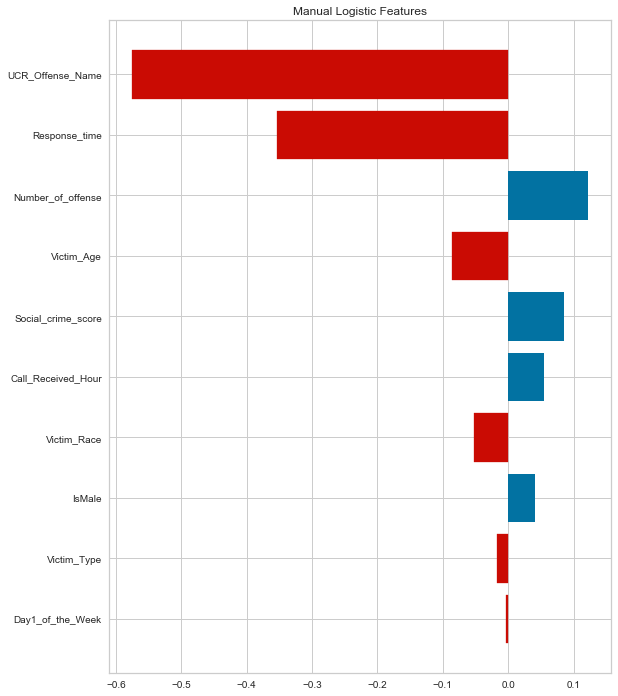

[(-0.5758552281691659, 'UCR_Offense_Name'),
 (-0.35283089114947636, 'Response_time'),
 (-0.08600635613312456, 'Victim_Age'),
 (-0.052970238812414853, 'Victim_Race'),
 (-0.017613623285240434, 'Victim_Type'),
 (-0.0030315783798986096, 'Day1_of_the_Week'),
 (0.041294437694442666, 'IsMale'),
 (0.05400260610450153, 'Call_Received_Hour'),
 (0.08536841186152015, 'Social_crime_score'),
 (0.12230414969571246, 'Number_of_offense')]

In [39]:
plotCoef(regGridSearch.best_estimator_.coef_[0], inci_X.columns.values, "Manual Logistic Features")
list(sorted(zip(regGridSearch.best_estimator_.coef_.ravel(), inci_X.columns.values)))

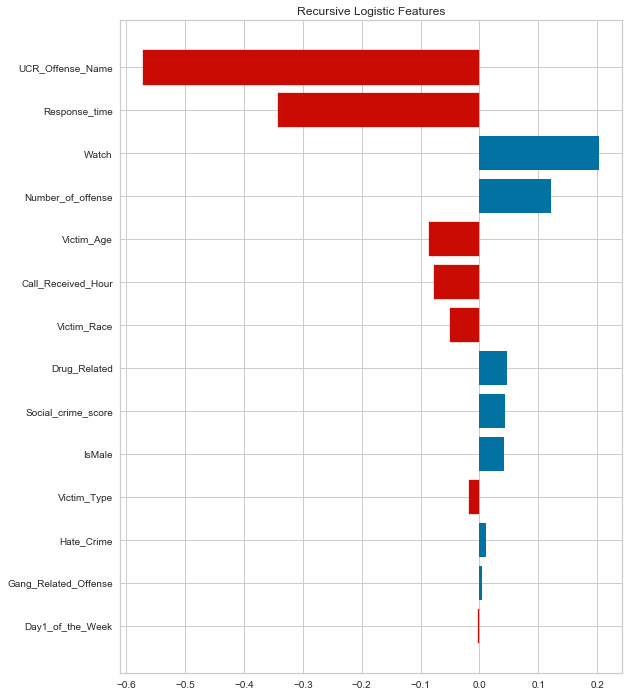

[(-0.5722184090085918, 'UCR_Offense_Name'),
 (-0.3422714761686839, 'Response_time'),
 (-0.08509185450004009, 'Victim_Age'),
 (-0.0777479220685694, 'Call_Received_Hour'),
 (-0.04948448681680277, 'Victim_Race'),
 (-0.018167662580084776, 'Victim_Type'),
 (-0.0030959583926247545, 'Day1_of_the_Week'),
 (0.004549868610561051, 'Gang_Related_Offense'),
 (0.011421790383313379, 'Hate_Crime'),
 (0.041762158466598, 'IsMale'),
 (0.042778428338309867, 'Social_crime_score'),
 (0.04658144451882535, 'Drug_Related'),
 (0.12133159626137077, 'Number_of_offense'),
 (0.20335487732419044, 'Watch')]

In [40]:
plotCoef(grid.best_estimator_.named_steps['logisticregression'].coef_.ravel(), inci_X_Rfe.columns.values, "Recursive Logistic Features")
list(sorted(zip(grid.best_estimator_.named_steps['logisticregression'].coef_.ravel(), inci_X_Rfe.columns.values)))

### Interpreting SVM Fields

For SVM models, the interpretation of field importance is not as straight forward. Non-linear SVM models create hyperplanes in infinite dimensional space. To accomplish this the source data used in the analysis must be mapped to a higher dimentional space and as a result is very different from the original data. Because of this it is not possible to determine feature weights like we did with the logisitc regessions above.

However, we can examine individual features to investigate how SVM approaches classification problems.**** EXPLANATION

In [ ]:
#Credit To:
####http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html
from matplotlib import pyplot as plt

#R and RA
pX = pd.DataFrame()

pX['a'] = inci_X_SVM['IsMale']
pX['b'] = inci_X_SVM['Number_of_offense']

psvc = SVC(kernel='linear', C=0.5, gamma='auto').fit(pX, inci_Y)

pXAmin = pX['a'].min() - 1
pXAmax = pX['a'].max() + 1
pXBmin = pX['b'].min() - 1
pXBmax = pX['b'].max() + 1

pxx, pyy = np.meshgrid(np.arange(pXAmin, pXAmax, 10), np.arange(pXBmin, pXBmax, 10))

plt.subplot(1, 1, 1)

pZ = psvc.predict(np.c_[pxx.ravel(), pyy.ravel()])

pZ = pZ.reshape(pxx.shape)
plt.contourf(pxx, pyy, pZ, cmap=plt.cm.Paired, alpha=0.8)

plt.scatter(pX['a'], pX['b'], c=inci_Y, cmap=plt.cm.Paired)
plt.xlabel('UCR_Offense_Name')
plt.ylabel('Number_of_offense')
plt.xlim(pxx.min(), pxx.max())
plt.title('SVM:  UCR_Offense_Name and Number_of_offense')
plt.show()

###### Key References

https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017ComparingSegregatedHighSchoolCampuses.ipynb (Logit) http://www.cs.toronto.edu/~kswersky/wp-content/uploads/svm_vs_lr.pdf

# LOGISTIC REGRESSION ROC CURVE

In [30]:
from sklearn.model_selection import train_test_split

# Extract the numpy arrays from the data frame
X = inci_X.as_matrix()
y = inci_Y.as_matrix()

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

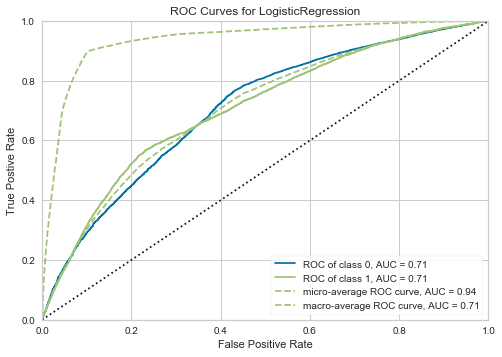

In [31]:
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ROCAUC

# Instantiate the classification model and visualizer
logistic = LogisticRegression()
visualizer = ROCAUC(logistic)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

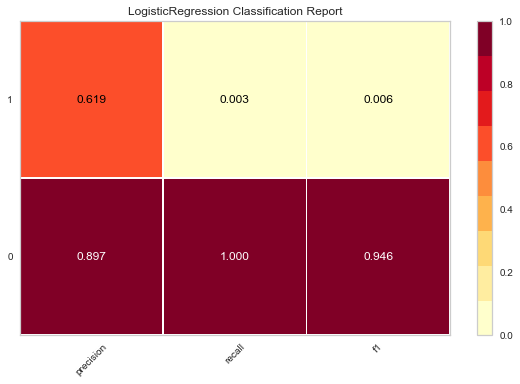

In [33]:
# CLASSIFICATION REPORT
from yellowbrick.classifier import ClassificationReport
from sklearn.linear_model import LogisticRegression
viz = ClassificationReport(LogisticRegression())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

# SVM

In [42]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Create classification dataset
X= inci_X_SVM
Y = inci_Y

# classes = ["ARRESTED", "NOT ARRESTED"]
# Perform 80/20 training/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    random_state=42)

In [43]:
# CLASSIFICATION REPORT
from yellowbrick.classifier import ClassificationReport
# from sklearn.linear_model import SVC
from sklearn.svm import SVC
viz = ClassificationReport(SVC())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.classifier import ClassPredictionError

# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    SVC(), classes=classes
)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
g = visualizer.poof()

### END OF REPORT